In [156]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

sns.set(font_scale=1.2)
sns.set_style("white")

In [157]:
# function for processing and simplifying the dataset
def select_and_rename(df, mapping):
    """
    Helper: Selects columns of df using the keys of the mapping dict.
    It renames the columns to the values of the mappings dict.
    """
    # select subset of columns
    dff = df[list(mapping.keys())]
    # rename 
    for k, v in mapping.items():
        dff.rename(columns={k: v}, inplace=True)
    return dff

def replaceSize(df):
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i http://20.0.0.254:8888/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k http://20.0.0.254:8888/bunny.mp4", "big")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -i -X 20.0.0.254:3128 http://40.0.0.254:80/", "small")
    df["size"] = df["size"].str.replace("ab -c 1 -t 60 -n 99999999 -e /tngbench_share/ab_dist.csv -s 60 -k -X 20.0.0.254:3128 http://40.0.0.254:80/bunny.mp4", "big")
    return df

In [161]:
# Load data from path
web1 = pd.read_csv("vnf_data/csv_experiments_WEB1.csv")
web2 = pd.read_csv("vnf_data/csv_experiments_WEB2.csv")
web3 = pd.read_csv("vnf_data/csv_experiments_WEB3.csv")

# do processing, renaming and selection
web1["vnf"] = "nginx"
web2["vnf"] = "haproxy"
web3["vnf"] = "squid"

mapping = {
    "param__func__mp.input__cmd_start": "size",
    "metric__mp.input.vdu01.0__ab_transfer_rate_kbyte_per_second": "Max. throughput [kB/s]",
}

mapping01 = mapping.copy()
mapping01["param__func__de.upb.lb-nginx.0.1__cpu_bw"] = "CPU"

mapping02 = mapping.copy()
mapping02["param__func__de.upb.lb-haproxy.0.1__cpu_bw"] = "CPU"

mapping03 = mapping.copy()
mapping03["param__func__de.upb.px-squid.0.1__cpu_bw"] = "CPU"

web1 = select_and_rename(web1, mapping01)
web2 = select_and_rename(web2, mapping02)
web3 = select_and_rename(web3, mapping03)

web1 = replaceSize(web1)
web2 = replaceSize(web2)
web3 = replaceSize(web3)

In [162]:
# select sub-datasets with small and large flows
web1_small = web1.loc[web1["size"] == "small"]
web1_big = web1.loc[web1["size"] == "big"]

web2_small = web2.loc[web2["size"] == "small"]
web2_big = web2.loc[web2["size"] == "big"]

web3_small = web3.loc[web3["size"] == "small"]
web3_big = web3.loc[web3["size"] == "big"]

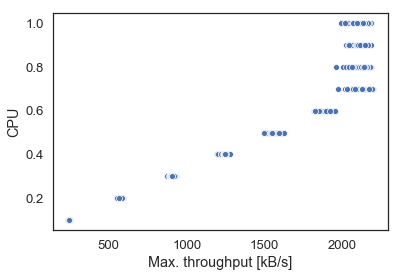

In [163]:
# plot cpu and Max. throughput [kB/s]
# sns.scatterplot(web1_small['Max. throughput [kB/s]'], web1_small['CPU'])
# sns.scatterplot(web1_big['Max. throughput [kB/s]'], web1_big['CPU'])
# sns.scatterplot(web2_small['Max. throughput [kB/s]'], web2_small['CPU'])
# sns.scatterplot(web2_big['Max. throughput [kB/s]'], web2_big['CPU'])
sns.scatterplot(web3_small['Max. throughput [kB/s]'], web3_small['CPU'])
# sns.scatterplot(web3_big['Max. throughput [kB/s]'], web3_big['CPU'])

In [164]:
def display_scores(scores):
    print(f"Mean: {scores.mean()}")
    print(f"Std: {scores.std()}")
    
def do_cv(model, X_train, y_train, k=5):
    # train score
    print("Train score:")
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    display_scores(rmse)
    
    # CV score
    print("CV score:")
    scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=k)
    rmse = np.sqrt(-scores)
    display_scores(rmse)
    
    return rmse
    
def predict_plot_all(model, X, y):
    name = type(model).__name__
    model.fit(X, y)
    y_pred = model.predict(X)
    plt.scatter(X, y, label='True')
    plt.scatter(X, y_pred, label=name)
    plt.legend()
    
    
def check_model(data, model):
    """Do test, train split; k-fold CV; and visualize"""
    name = type(model).__name__
    print(f"\n{name}")
    
    # prepare train and test set
    X = data[['Max. throughput [kB/s]']]
    y = data['CPU']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    rmse = do_cv(model, X_train, y_train)
#     predict_plot_all(model, X, y)

    return rmse

In [165]:
data = web3_small

rmse_lin = check_model(data, LinearRegression())
rmse_ridge = check_model(data, Ridge())
rmse_svr = check_model(data, SVR())
rmse_forest = check_model(data, RandomForestRegressor())
rmse_boost = check_model(data, GradientBoostingRegressor())
rmse_mlp = check_model(data, MLPRegressor())


LinearRegression
Train score:
Mean: 0.09219967179172997
Std: 0.0
CV score:
Mean: 0.092416708779461
Std: 0.0016865982645713578

Ridge
Train score:
Mean: 0.09256711006861562
Std: 0.0
CV score:
Mean: 0.0924736870290088
Std: 0.007409906713819136

SVR
Train score:
Mean: 0.09047399261169459
Std: 0.0
CV score:


c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\stefan\git-repos\work\ai\venv\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
c:\users\stefan\git-repos\work\ai\ven

Mean: 0.14283356425885477
Std: 0.005044340764062185

RandomForestRegressor
Train score:
Mean: 0.03533576193360732
Std: 0.0
CV score:
Mean: 0.08626885684961672
Std: 0.00944501960823933

GradientBoostingRegressor
Train score:
Mean: 0.04998645981930307
Std: 0.0
CV score:
Mean: 0.07686918096512592
Std: 0.004134848255614316

MLPRegressor
Train score:
Mean: 0.10241485922372909
Std: 0.0
CV score:
Mean: 0.12672324399830032
Std: 0.0371909378535839


In [170]:
# bar plot comparing the RMSE of the different algorithms
def barplot_rmse(scores, labels, data_name):
    assert len(scores) == len(labels)
    
    # preparation
    rmse_mean = [s.mean() for s in scores]
    rmse_std = [s.std() for s in scores]
    x = np.arange(len(labels))

    # plot
    fig, ax = plt.subplots()
    plt.bar(x, rmse_mean, color='grey', yerr=rmse_std, capsize=5)

    # labels
    ax.set_xlabel('Machine learning models')
    ax.set_ylabel('RMSE')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    fig.savefig(f'plots/{data_name}_rmse.pdf', bbox_inches='tight')

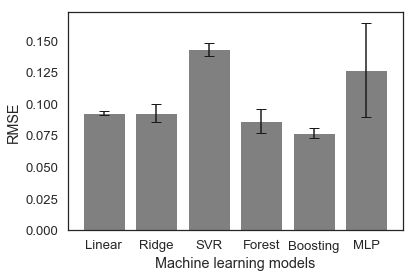

In [171]:
labels = ['Linear', 'Ridge', 'SVR', 'Forest', 'Boosting', 'MLP']
scores = [rmse_lin, rmse_ridge, rmse_svr, rmse_forest, rmse_boost, rmse_mlp]

barplot_rmse(scores, labels, 'web3_small')

In [ ]:
# TODO: tune hyper params and check difference